#Proyecto de Tópicos de Análisis de Video
Nicolás Sepúlveda - Sebastián Paillao


In [1]:
import sys
print(sys.executable)

c:\Users\nic_s\anaconda3\envs\deepgpu\python.exe


Configuración general e importaciones importantes

In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import cv2
import numpy as np
from pathlib import Path
import warnings
import pandas as pd
from torch.utils.data import random_split
warnings.filterwarnings("ignore")

# === Configuración (CUDA/CPU) ===
LABEL_SMOOTH = 0.10 
CLIP_DURATION = 2.56  # segundos
STRIDE = 2.1  # segundos
PRETRAINED_MODEL = "I3D_8x8_R50_pytorchvideo.pyth"  # Formato PyTorchVideo
LABELS = ["Normal", "Robo", "Violencia"]
TARGET_SIZE = (224, 224)
NUM_FRAMES = 32

Configuración del hardware a utilizar, según disponibilidad de GPU

In [3]:
def get_hardware_config():
    if torch.cuda.is_available():
        # Detectar capacidad de VRAM automáticamente
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🔍 VRAM detectada: {gpu_memory_gb:.1f} GB")
        
        # Configuración solicitada:
        batch_size = 3
        num_workers = 0
            
        print(f"⚡ Configuración optimizada: batch_size={batch_size}, num_workers={num_workers}")
        
        return {
            'batch_size': batch_size,
            'num_workers': num_workers,
            'pin_memory': True,
            'use_mixed_precision': True,
            'cuda_device': 0
        }
    else:
        return {
            'batch_size': 1,  # CPU usa batch size más pequeño
            'num_workers': 0,
            'pin_memory': False,
            'use_mixed_precision': False,
            'cuda_device': None
        }

# Obtener configuración según hardware disponible
config = get_hardware_config()

# Verificar CUDA y configurar device
if torch.cuda.is_available():
    device = torch.device(f'cuda:{config["cuda_device"]}')
    gpu_name = torch.cuda.get_device_name(config["cuda_device"])
    gpu_memory = torch.cuda.get_device_properties(config["cuda_device"]).total_memory / 1e9
    print(f"🚀 GPU detectada: {gpu_name}")
    print(f"💾 VRAM total: {gpu_memory:.1f} GB")
    print(f"🖥️  Device: {device}")
    
    # Limpiar cache de GPU
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    print(f"⚠️  CUDA no disponible, usando CPU")
    print(f"🖥️  Device: {device}")
    print(f"💡 Para usar GPU, ejecuta: setup_cuda.bat")


🔍 VRAM detectada: 4.3 GB
⚡ Configuración optimizada: batch_size=3, num_workers=0
🚀 GPU detectada: NVIDIA GeForce GTX 1650 Ti
💾 VRAM total: 4.3 GB
🖥️  Device: cuda:0


#### Clase para clips con Sliding Window
Se crea una clase para generar clips usando una sliding window. Esto será útil para usar sobre los videos del dataset, tanto para el entrenamiento como para el testeo, pues I3D y modelos similares trabajan con clips, mientras que los videos del dataset pueden ser largos, por lo que necesitaremos crear un conjunto de clips a partir de los videos. Estos se armarán con una cantidad de frames indicada, dividiendo el video original considerando el stride dado, para solapamiento de los clips.

In [4]:
# === Dataset con sliding window ===
class SlidingWindowVideoDataset(Dataset):
    def __init__(self, video_paths, clip_duration, stride, num_frames=64, transform=None):
        self.clips = []
        self.clip_duration = clip_duration
        self.stride = stride
        self.num_frames = num_frames
        self.transform = None
        
        # Generar todos los clips con sliding window
        for video_path, label in video_paths:
            clips_from_video = self._generate_clips(video_path, label)
            self.clips.extend(clips_from_video)
        
        print(f"📊 Total de clips generados: {len(self.clips)}")
    
    def _generate_clips(self, video_path, label):
        """Genera clips usando sliding window para un video"""
        try:
            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            
            if fps <= 0:
                return []
            
            video_duration = total_frames / fps
            clips = []
            
            start_time = 0.0
            while start_time + self.clip_duration <= video_duration:
                start_frame = int(start_time * fps)
                end_frame = int((start_time + self.clip_duration) * fps)
                
                clips.append({
                    'video_path': video_path,
                    'label': label,
                    'start_frame': start_frame,
                    'end_frame': end_frame,
                    'fps': fps
                })
                
                start_time += self.stride
            
            return clips
            
        except Exception as e:
            print(f"❌ Error procesando {video_path}: {e}")
            return []
    
    def __len__(self):
        return len(self.clips)
    
    def __getitem__(self, idx):
        clip_info = self.clips[idx]
        
        # Cargar frames del clip
        frames = self._load_video_clip(
            clip_info['video_path'],
            clip_info['start_frame'],
            clip_info['end_frame']
        )
        
        # Convertir a tensor y aplicar transformaciones
        video_tensor = self._preprocess_frames(frames)

        video_id = Path(clip_info['video_path']).stem
        
        return {
            'video': video_tensor,
            'label': torch.tensor(clip_info['label'], dtype=torch.long),
            'video_id': video_id
        }
    
    def _load_video_clip(self, video_path, start_frame, end_frame):
        """Carga frames específicos de un video"""
        cap = cv2.VideoCapture(video_path)
        frames = []
        
        # Calcular índices de frames a extraer
        total_clip_frames = end_frame - start_frame
        if total_clip_frames <= 0:
            cap.release()
            return [np.zeros((*TARGET_SIZE, 3), dtype=np.uint8)] * self.num_frames
        
        # Submuestreo uniforme para obtener NUM_FRAMES
        frame_indices = np.linspace(start_frame, end_frame-1, self.num_frames, dtype=int)
        
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, TARGET_SIZE)
                frames.append(frame)
            else:
                # Usar último frame válido si hay error
                if frames:
                    frames.append(frames[-1])
                else:
                    frames.append(np.zeros((*TARGET_SIZE, 3), dtype=np.uint8))
        
        cap.release()
        
        # Asegurar que tenemos exactamente NUM_FRAMES
        while len(frames) < self.num_frames:
            frames.append(frames[-1] if frames else np.zeros((*TARGET_SIZE, 3), dtype=np.uint8))
        
        return frames[:self.num_frames]
    
    def _preprocess_frames(self, frames):
        """Convierte frames a tensor y aplica transformaciones"""
        processed = []
        
        # ---------- A) aplica la misma aleatoriedad a todo el clip ----------
        if self.transform is not None:
            # Para que flip y jitter sean coherentes en los 16 frames,
            # fijamos una semilla por clip (opcional pero práctico).
            seed = torch.randint(0, 10_000, (1,)).item()
        
        for f in frames:
            img = f  # ndarray RGB [H,W,3]
            
            if self.transform is not None:
                torch.manual_seed(seed)       # ➌ misma rand para el clip
                img = self.transform(img)     # devuelve Tensor CxHxW [0,1] y normalizado
            else:
                img = torch.from_numpy(img).permute(2,0,1).float() / 255.

            processed.append(img)
        
        video_tensor = torch.stack(processed, dim=1)  # [C, T, H, W]
        return video_tensor


#### Transformaciones
Se aplicarán las siguientes transformaciones a los videos. Para el train set se aplican un conjunto de transformaciones para hacer data augmentation. Para validación y test, transformaciones enfocadas a normalización.

In [5]:
from torchvision import transforms

# ---- transform para ENTRENAMIENTO ----
TRAIN_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),                       # ndarray → PIL
    transforms.RandomResizedCrop(TARGET_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.12, 0.12),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.45]*3, [0.225]*3),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.12))
])

# ---- transform para VALIDACIÓN / TEST ----
VAL_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.45, 0.45, 0.45],
                         [0.225,0.225,0.225]),
])


In [6]:
# === Funciones de utilidad ===
def recolectar_videos(base_dir):
    """Recolecta todas las rutas de videos con sus etiquetas de forma recursiva"""
    video_paths = []
    label_to_idx = {label: idx for idx, label in enumerate(LABELS)}
    
    for label in LABELS:
        label_dir = Path(base_dir) / label
        if not label_dir.exists():
            print(f"⚠️ Directorio no encontrado: {label_dir}")
            continue
        
        # Búsqueda recursiva de videos .mp4
        for video_file in label_dir.glob("**/*.mp4"):
            video_paths.append((str(video_file), label_to_idx[label]))
    
    return video_paths

def contar_videos_por_etiqueta(video_paths):
    """Cuenta videos por cada etiqueta"""
    conteo = defaultdict(int)
    for _, label_idx in video_paths:
        label_name = LABELS[label_idx]
        conteo[label_name] += 1
    
    print("\n📊 [Resumen de videos por clase]")
    for label, count in conteo.items():
        print(f"   {label}: {count} videos")
    print()

def estimar_clips_totales(video_paths):
    """Estima el número total de clips que se generarán"""
    total_clips = 0
    clips_por_clase = defaultdict(int)
    
    for video_path, label_idx in video_paths:
        try:
            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            
            if fps > 0:
                video_duration = total_frames / fps
                num_clips = max(0, int((video_duration - CLIP_DURATION) / STRIDE) + 1)
                total_clips += num_clips
                clips_por_clase[LABELS[label_idx]] += num_clips
                
        except Exception as e:
            print(f"❌ Error estimando clips para {video_path}: {e}")
    
    print("📊 [Estimación de clips por sliding window]")
    for label, count in clips_por_clase.items():
        print(f"   {label}: {count} clips")
    print(f"   Total estimado: {total_clips} clips\n")

### Armado del dataset
Las siguientes funciones son para armar el conjunto de clips que será utilizado por el modelo. Se utiliza la clase Sliding Window anteriormente definida para la creación de los clips, incluyendo las transformaciones definidas anteriormente según si los videos son para entrenamiento o para validación/test, utilizando DataLoader.

In [7]:
# Recolectar videos de entrenamiento y validación
def recolectar_datasets():
    print(f"\n📂 Buscando videos de ENTRENAMIENTO en: {TRAIN_DIR}")
    train_video_paths = recolectar_videos(TRAIN_DIR)
    if not train_video_paths:
        print("❌ No se encontraron videos de entrenamiento. Verifica la estructura de carpetas.")

    print(f"✅ Total de videos de entrenamiento: {len(train_video_paths)}")
    contar_videos_por_etiqueta(train_video_paths)

    print(f"\n📂 Buscando videos de VALIDACIÓN en: {VALIDATION_DIR}")
    val_video_paths = recolectar_videos(VALIDATION_DIR)
    if not val_video_paths:
        print("❌ No se encontraron videos de validación. Verifica la estructura de carpetas.")

    print(f"✅ Total de videos de validación: {len(val_video_paths)}")
    contar_videos_por_etiqueta(val_video_paths)

    # Crear datasets para entrenamiento y validación
    print("\n🔄 Creando datasets con sliding window...")
    train_dataset = SlidingWindowVideoDataset(
        video_paths=train_video_paths,
        clip_duration=CLIP_DURATION,
        stride=STRIDE,
        num_frames=NUM_FRAMES,
        transform=TRAIN_TRANSFORM
    )
    val_dataset = SlidingWindowVideoDataset(
        video_paths=val_video_paths,
        clip_duration=CLIP_DURATION,
        stride=STRIDE,
        num_frames=NUM_FRAMES,
        transform=VAL_TRANSFORM
    )

    # Crear dataloaders para entrenamiento y validación con optimizaciones
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        drop_last=True,
        **({"persistent_workers": True, "prefetch_factor": 2} if config['num_workers'] > 0 else {})
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=config['pin_memory'],
        drop_last=True,
        **({"persistent_workers": True, "prefetch_factor": 2} if config['num_workers'] > 0 else {})
    )

    print(f"✅ DataLoaders creados: {len(train_loader)} batches de entrenamiento, {len(val_loader)} batches de validación")
    return train_loader, val_loader


### Creación del modelo
Funciones para creación del modelo y carga de pesos preentrenados cuando se utilicen. Se parametrizan algunas opciones para la creación, como el drop_out, la cantidad de clases y el congelamiento de capas.

In [8]:
# === Modelo I3D parametrizado ===
from typing import Iterable, Union, Optional
import torch.nn as nn
from pytorchvideo.models.hub import i3d_r50


def crear_modelo_i3d(
        dropout_p: Optional[float] = None,                   
        freeze_until: Union[int, Iterable[int]] = 4,
        pretrain_path: Optional[str] = PRETRAINED_MODEL,
        num_clases: int = 3,
        freeze_backbone: bool = True
) -> nn.Module:
    """
    Devuelve un I3D-ResNet50 con la cabeza adaptada a `num_clases`.

    • `dropout_p`     – probabilidad de Dropout en la head.
    • `freeze_until`  – hasta qué bloque congelar:
        – int  : congela bloques 0 … freeze_until (incl.).
        – iter : congela los índices listados, e.g. (0,1,2,5).
    • `pretrain_path` – ruta a pesos preentrenados (.pyth) o None.
    • `freeze_backbone` False → no congela nada.
    """
    try:
        print("🔄 Creando modelo I3D-ResNet50…")
        model = i3d_r50(pretrained=False)

        # 1) Pesos preentrenados
        if pretrain_path:
            cargar_pesos_preentrenados(model, pretrain_path)

        # 2) Head: Dropout + proyección
        head = model.blocks[-1]
        if dropout_p is None:
            head.dropout = nn.Identity()          # arquitectura sin Dropout
            print("✅ Head: SIN Dropout")
        else:
            head.dropout = nn.Dropout(dropout_p)
            print(f"✅ Head: Dropout p={dropout_p}")

        head.proj = nn.Linear(head.proj.in_features, num_clases)
        print(f"   ↳ proyección → {num_clases} clases")

        # 3) Congelado selectivo del backbone
        if freeze_backbone:
            if isinstance(freeze_until, int):
                freeze_set = {f"blocks.{i}" for i in range(freeze_until + 1)}
            else:                       # iterable de índices
                freeze_set = {f"blocks.{i}" for i in freeze_until}

            frozen, trainable = 0, 0
            for name, p in model.named_parameters():
                block_tag = '.'.join(name.split('.', 2)[:2])   # "blocks.X"
                if block_tag in freeze_set:
                    p.requires_grad = False
                    frozen += 1
                else:
                    trainable += 1
            print(f"🧊  Capas congeladas: {frozen}  |  Entrenables: {trainable}")

        return model
        
    except ImportError:
        print("❌ PyTorchVideo no encontrado. Instalando...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorchvideo"])
        print("✅ PyTorchVideo instalado. Reintentando...")
        return crear_modelo_i3d()
        
    except Exception as e:
        print(f"❌ Error creando modelo I3D: {e}")
        print("🔄 Intentando método alternativo...")
        try:
            # Fallback al método anterior
            from pytorchvideo.models.resnet import create_resnet
            model = create_resnet(
                input_channel=3,
                model_depth=50,
                model_num_class=400
            )
            print("✅ Modelo creado con método alternativo")
            return model
        except Exception as e2:
            print(f"❌ Error con método alternativo: {e2}")
            exit(1)


def descargar_modelo_preentrenado():
    """Descarga el modelo I3D preentrenado si no existe"""
    modelo_url = "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/I3D_8x8_R50.pyth"
    modelo_local = PRETRAINED_MODEL
    
    if not os.path.exists(modelo_local):
        print(f"📥 Descargando modelo preentrenado I3D...")
        print(f"🔗 URL: {modelo_url}")
        try:
            import urllib.request
            urllib.request.urlretrieve(modelo_url, modelo_local)
            print(f"✅ Modelo descargado: {modelo_local}")
            return True
        except Exception as e:
            print(f"❌ Error descargando modelo: {e}")
            print(f"💡 Puedes descargarlo manualmente desde: {modelo_url}")
            return False
    else:
        print(f"✅ Modelo preentrenado encontrado: {modelo_local}")
        return True

def cargar_pesos_preentrenados(model, pretrained_path):
    """Carga pesos preentrenados desde archivos .pth o .pyth"""
    if os.path.exists(pretrained_path):
        try:
            checkpoint = torch.load(pretrained_path, map_location='cpu')
            
            # Detectar formato del checkpoint
            if isinstance(checkpoint, dict) and 'model_state' in checkpoint:
                # Formato PyTorchVideo (.pyth)
                state_dict = checkpoint['model_state']
                print(f"🔍 Detectado formato PyTorchVideo (.pyth)")
            elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
                # Formato estándar con state_dict
                state_dict = checkpoint['state_dict']
                print(f"🔍 Detectado formato con state_dict")
            else:
                # Formato directo (solo state_dict)
                state_dict = checkpoint
                print(f"🔍 Detectado formato directo")
            
            # Intentar cargar con strict=False para ignorar incompatibilidades
            missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
            
            # Contar cuántas capas se cargaron exitosamente
            total_params = len(model.state_dict())
            loaded_params = total_params - len(missing_keys)
            
            if len(missing_keys) > total_params * 0.5:  # Si más del 50% no coincide
                print(f"⚠️ Arquitectura incompatible: {len(missing_keys)}/{total_params} capas no coinciden")
                print(f"💡 Entrenando desde cero (recomendado para esta arquitectura)")
                return False
            else:
                print(f"✅ Pesos preentrenados cargados: {loaded_params}/{total_params} capas")
                if missing_keys:
                    print(f"⚠️ {len(missing_keys)} capas se inicializarán aleatoriamente")
                return True
                
        except Exception as e:
            print(f"⚠️ Error cargando pesos: {e}")
            print(f"💡 Continuando entrenamiento desde cero")
            return False
    else:
        print(f"⚠️ Archivo {pretrained_path} no encontrado")
        print(f"💡 Entrenando desde cero")
        return False

## Función de entrenamiento
En esta función se condensa todo el flujo de entrenamiento de un modelo, a partir de distintos parámetros y utilizando los clips de train y validación construidos con dataLoader y Sliding Window. Se utiliza Mixed Precision y otras adaptaciones para mejorar rendimiento de uso de GPU. Se incluye un early stopping y se guardan los checkpoints (en caso de interrupción para continuar entrenamiento) y el mejor modelo en caso de detectar sobre-ajuste. Además, se exportan en un .csv las métricas del entrenamiento, para su posterior análisis. Se incorporan acá diferentes configuraciones como el uso de un scheduler para el LR y un batch accumulation, para aumentar el tamaño del batch virtualmente, dando mayor estabilidad al entrenamiento, en condiciones donde la GPU no sea capaz de manejar un batch real más grande. Se incluye una etapa de validación tras cada época.

In [9]:
# === Entrenamiento adaptativo (CUDA/CPU) ===
def entrenar_modelo(model, train_loader, val_loader, device, num_epochs, config,
                    class_weights=None):
    """Función principal de entrenamiento con validación y early stopping"""
    model.to(device)
    
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE, weight_decay=5e-4
    )
    # Learning rate scheduler para convergencia más rápida
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.3, patience=2
    )
    LABEL_SMOOTH = 0.10    

    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(
            weight=class_weights.to(device),
            label_smoothing=LABEL_SMOOTH
        )
    else:
        criterion = nn.CrossEntropyLoss(
            label_smoothing=LABEL_SMOOTH
        )

    
    scaler = None
    if config['use_mixed_precision'] and device.type == 'cuda':
        from torch.cuda.amp import GradScaler, autocast
        scaler = GradScaler()
        print("✅ Mixed Precision habilitado (AMP)")

    if device.type == 'cuda':
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        # Optimizaciones adicionales para GPU
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # Prellenado de memoria GPU para evitar fragmentación
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        print(f"🚀 Optimizaciones CUDA habilitadas (TF32, cuDNN benchmark)")
        print(f"📊 VRAM disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    print(f"\n🚀 [Entrenamiento iniciado en {device}]")
    print(f"📋 Configuración: {num_epochs} épocas, batch_size={config['batch_size']}, lr={LEARNING_RATE}")
    
    # Diagnóstico de utilización de GPU
    if device.type == 'cuda':
        total_vram = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"💡 TIPS para maximizar GPU:")
        print(f"   - Si GPU < 2GB durante entrenamiento, considera aumentar batch_size")
        print(f"   - VRAM total disponible: {total_vram:.1f}GB")
        print(f"   - Batch size actual: {config['batch_size']}")
        if config['batch_size'] < 4 and total_vram > 8:
            print(f"   ⚠️ Puedes intentar batch_size más grande (4-6) con {total_vram:.0f}GB VRAM")

    history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Acumulación de gradientes
    accum_steps = 2

    for epoch in range(num_epochs):
        model.train()  # Modo entrenamiento
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        epoch_start_time = time.time()
        
        print(f"\n📅 --- Época {epoch+1}/{num_epochs} ---")
        
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx == 0:
                print("✅ Primer batch cargado y procesado.")            
            batch_start_time = time.time()
            videos = batch['video'].to(device, non_blocking=config['pin_memory'])
            labels = batch['label'].to(device, non_blocking=config['pin_memory'])
            
            # Adaptacion para acumulación de gradientes
            if (batch_idx % accum_steps) == 0:
                optimizer.zero_grad(set_to_none=True)
            
            if scaler is not None:
                with autocast():
                    outputs = model(videos)
                    loss = criterion(outputs, labels) / accum_steps 
                scaler.scale(loss).backward()
            else:
                outputs = model(videos)
                loss = criterion(outputs, labels) / accum_steps
                loss.backward()

            # Actualizar gradientes cada accum_steps
            if (batch_idx + 1) % accum_steps == 0:
                if scaler is not None:          # ── caso AMP
                    scaler.step(optimizer)
                    scaler.update()
                else:                            # ── caso normal
                    optimizer.step()

            running_loss += loss.item() * accum_steps
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Imprimir estado en cada lote para monitoreo detallado
            batch_time = time.time() - batch_start_time
            remaining_batches = len(train_loader) - batch_idx - 1
            # ETA más preciso basado en tiempo promedio por lote
            avg_batch_time = (time.time() - epoch_start_time) / (batch_idx + 1)
            eta_seconds = avg_batch_time * remaining_batches
            accuracy = 100 * correct_predictions / total_samples
            gpu_memory = torch.cuda.memory_allocated(0) / 1e9 if device.type == 'cuda' else 0
            gpu_memory_peak = torch.cuda.max_memory_allocated(0) / 1e9 if device.type == 'cuda' else 0

            # Análisis de distribución de predicciones para detectar sobreajuste
            with torch.no_grad():
                _, predicted_batch = torch.max(outputs.data, 1)
                unique_preds, counts = torch.unique(predicted_batch, return_counts=True)
                pred_distribution = {LABELS[pred.item()]: count.item() for pred, count in zip(unique_preds, counts)}
                
            log_msg = (
                f"   [{batch_idx+1:4d}/{len(train_loader):4d}] "
                f"Loss: {(loss.item()*accum_steps):.4f} | "
                f"Acc: {accuracy:.2f}% | "
                f"ETA: {int(eta_seconds):3d}s | "
                f"Preds: {pred_distribution}"
            )
            if device.type == 'cuda':
                log_msg += f" | GPU: {gpu_memory:.1f}GB / peak: {gpu_memory_peak:.1f}GB"
            if batch_idx % 200 == 0 or batch_idx == len(train_loader) - 1:
                print(log_msg)                

            # Limpiar cache menos frecuentemente para mejor rendimiento
            if batch_idx % 100 == 0 and device.type == 'cuda':
                torch.cuda.empty_cache()
        
        epoch_time = time.time() - epoch_start_time
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_predictions / total_samples
        
        if (len(train_loader) % accum_steps) != 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            else:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        # Validación
        print(f"\n🔍 Validando al final de la época {epoch+1}...")
        val_loss, val_accuracy = validar_modelo(model, val_loader, device, criterion)
        
        # Actualizar learning rate basado en val_loss
        scheduler.step(val_loss)
        
        print(f"   ✅ Época {epoch+1} completada en {int(epoch_time)}s")
        print(f"      Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"      Valid Loss: {val_loss:.4f}, Valid Acc: {val_accuracy:.2f}%")
        print(f"      LR actual: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Análisis de sobreajuste
        gap_loss = abs(avg_train_loss - val_loss)
        gap_acc = abs(train_accuracy - val_accuracy)
        
        if gap_loss > 0.5:
            print(f"      ⚠️ SOBREAJUSTE DETECTADO: Gap Loss = {gap_loss:.3f}")
        if gap_acc > 20:
            print(f"      ⚠️ SOBREAJUSTE DETECTADO: Gap Accuracy = {gap_acc:.1f}%")
        if val_loss > avg_train_loss * 1.5:
            print(f"      ⚠️ Posible sobreajuste: Val Loss {val_loss:.3f} >> Train Loss {avg_train_loss:.3f}")
        
        # Métricas de aprendizaje real
        if epoch > 0:
            prev_train_loss = history[-1]['train_loss'] if history else float('inf')
            if avg_train_loss < prev_train_loss:
                print(f"      ✅ Progreso consistente: Loss bajó {prev_train_loss - avg_train_loss:.4f}")
            else:
                print(f"      📈 Loss aumentó desde época anterior: +{avg_train_loss - prev_train_loss:.4f}")

        # Exportar métricas
        history.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })
        
        append_metrics_csv(history[-1], METRICS_FILE)

        # Guardar checkpoint al final de cada época
        checkpoint = {
            'epoch': epoch + 1,  # número de época actual
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "amp_scaler_state_dict": scaler.state_dict() if scaler else None,
            'history': history,
            'best_val_loss': best_val_loss,
        }

        # Obs: solo guardar último checkpoint, en caso de interrupciones
        torch.save(checkpoint, "checkpoint_latest.pth")
        print(f"💾 Checkpoint N°{epoch+1} guardado en checkpoint_latest.pth")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            print(f"   ⭐ Nuevo mejor modelo guardado (Val Loss: {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            print(f"   📉 Sin mejora por {epochs_no_improve} épocas")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\n🛑 Early stopping en la época {epoch+1}")
            break

        if device.type == 'cuda':
            print(f"      VRAM máxima usada: {torch.cuda.max_memory_allocated(0) / 1e9:.1f} GB")
            torch.cuda.reset_peak_memory_stats()

    # Cargar el mejor modelo y guardarlo
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    torch.save(model.state_dict(), OUTPUT_MODEL)
    print(f"\n💾 Mejor modelo guardado como '{OUTPUT_MODEL}'")

from torch.cuda.amp import autocast

# === Validación y Early Stopping ===
def validar_modelo(model, dataloader, device, criterion):
    """Evalúa el modelo en el conjunto de validación"""
    model.eval()  # Modo evaluación
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # No calcular gradientes
        for batch in dataloader:
            videos = batch['video'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            with autocast(enabled=device.type == "cuda"):
                outputs = model(videos)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            if device.type == "cuda":
                del videos, labels, outputs
                torch.cuda.empty_cache()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy

import csv, os

def append_metrics_csv(history_row, csv_path="training_metrics.csv"):
    """Exporta el historial de métricas a un archivo csv"""
    header = list(history_row.keys())
    file_exists = os.path.isfile(csv_path)

    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        if not file_exists:
            writer.writeheader()
        writer.writerow(history_row)

### Función para orquestar entrenamiento
En esta función se ejecutan las tareas básicas de entrenamiento. Se usó inicialmente, pero después se prefiere, por flexibilidad y parametrización incompleta de las funciones, hacer llamados a cada función de acá con las personalizaciones necesarias de cada experimento.

In [10]:
def ejecutar_entrenamiento():
    """Función principal para ejecutar el entrenamiento"""
    # Crear el modelo con backbone congelado
    print("\n🧠 Configurando modelo I3D...")
    model = crear_modelo_i3d(num_clases=len(LABELS), freeze_backbone=True)

    # Descargar modelo preentrenado si no existe
    print("\n📦 Verificando modelo preentrenado...")
    descargar_modelo_preentrenado()

    # Mostrar información del modelo
    model_params = sum(p.numel() for p in model.parameters())
    print(f"📊 Parámetros del modelo: {model_params:,}")

    train_loader, val_loader = recolectar_datasets()
    
    # Entrenar
    entrenar_modelo(model, train_loader, val_loader, device, EPOCHS, config)

    print("\n🎉 ¡Entrenamiento completado!")
    if device.tyspe == 'cuda':
        print(f"🏁 VRAM final usada: {torch.cuda.memory_allocated(0) / 1e9:.1f} GB")


# Experimentos realizados con dataset limpio
En esta sección se muestran los resultados de los experimentos realizados con el dataset en versión limpia. Se realizaron 4 experimentos, variando la configuracion en cada uno para buscar mejoras ante sobreajuste

# Primer Experimento
Configuración inicial, transformaciones de augmentación de data más limitadas, se obtiene un modelo con un sobreajuste notorio de acuerdo a las métricas.
* Error en importaciones impidió que las métricas se guardaran externamente.

In [ ]:
%%time
EPOCHS = 10
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 2
TRAIN_DIR = "./tav_clean/training"
VALIDATION_DIR = "./tav_clean/validacion"
OUTPUT_MODEL = "i3d_finetuned_violencia_robo_normal.pth"
METRICS_FILE = "training_metrics.xlsx"
ejecutar_entrenamiento()


🧠 Configurando modelo I3D...
🔄 Creando modelo I3D-ResNet50 …
🔍 Detectado formato PyTorchVideo (.pyth)
✅ Pesos preentrenados cargados: 320/320 capas
✅ Capa final adaptada → 3 clases
🧊  Bloques 0-3 congelados

📦 Verificando modelo preentrenado...
✅ Modelo preentrenado encontrado: I3D_8x8_R50_pytorchvideo.pyth
📊 Parámetros del modelo: 27,230,019

📂 Buscando videos de ENTRENAMIENTO en: ./tav_clean/training
✅ Total de videos de entrenamiento: 274

📊 [Resumen de videos por clase]
   Normal: 115 videos
   Robo: 83 videos
   Violencia: 76 videos


📂 Buscando videos de VALIDACIÓN en: ./tav_clean/validacion
✅ Total de videos de validación: 57

📊 [Resumen de videos por clase]
   Normal: 17 videos
   Robo: 22 videos
   Violencia: 18 videos


🔄 Creando datasets con sliding window...
📊 Total de clips generados: 7401
📊 Total de clips generados: 1103
✅ DataLoaders creados: 3700 batches de entrenamiento, 551 batches de validación
✅ Mixed Precision habilitado (AMP)
🚀 Optimizaciones CUDA habilitadas (TF

ModuleNotFoundError: No module named 'openpyxl'

# Segundo experimento
Se liberaron más bloques para esta ronda, con un learning rate más pequeño. Se interrumpe entrenamiento tempranamente debido a que métricas no reportan mejoras significativas tras primera época y se encuentra que se puede aumentar el batch real, lo que, junto al batch accumulation, permitiría un entrenamiento más estable que esta ronda no permitiría.

In [ ]:
%%time
EPOCHS = 10
LEARNING_RATE = 3e-5
EARLY_STOPPING_PATIENCE = 2
TRAIN_DIR = "./tav_clean/training"
VALIDATION_DIR = "./tav_clean/validacion"
OUTPUT_MODEL = "i3d_finetuned_violencia_robo_normal.pth"
METRICS_FILE = "training_metrics.xlsx"

ckpt = torch.load("checkpoint_epoch_1.pth", map_location="cpu")

model = crear_modelo_i3d(num_clases=len(LABELS), freeze_backbone=False)
model.load_state_dict(ckpt["model_state_dict"])
missing, unexpected = model.load_state_dict(
        ckpt["model_state_dict"], strict=False)
print(f"🔁 Checkpoint cargado. Missing={len(missing)}, Unexpected={len(unexpected)}")

for name, p in model.named_parameters():
    p.requires_grad = any(name.startswith(f"blocks.{i}") for i in [3,4,5]) or "head" in name

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE, weight_decay=1e-5
)

train_loader, val_loader = recolectar_datasets()

entrenar_modelo(model, train_loader, val_loader, device, EPOCHS, config)

🔄 Creando modelo I3D-ResNet50 …
🔍 Detectado formato PyTorchVideo (.pyth)
✅ Pesos preentrenados cargados: 320/320 capas
✅ Head: Dropout 0.3 + proyección 3-clases
🔁 Checkpoint cargado. Missing=0, Unexpected=0

📂 Buscando videos de ENTRENAMIENTO en: ./tav_clean/training
✅ Total de videos de entrenamiento: 274

📊 [Resumen de videos por clase]
   Normal: 115 videos
   Robo: 83 videos
   Violencia: 76 videos


📂 Buscando videos de VALIDACIÓN en: ./tav_clean/validacion
✅ Total de videos de validación: 57

📊 [Resumen de videos por clase]
   Normal: 17 videos
   Robo: 22 videos
   Violencia: 18 videos


🔄 Creando datasets con sliding window...
📊 Total de clips generados: 7401
📊 Total de clips generados: 1103
✅ DataLoaders creados: 2467 batches de entrenamiento, 367 batches de validación
✅ Mixed Precision habilitado (AMP)
🚀 Optimizaciones CUDA habilitadas (TF32, cuDNN benchmark)
📊 VRAM disponible: 4.3 GB

🚀 [Entrenamiento iniciado en cuda:0]
📋 Configuración: 10 épocas, batch_size=3, lr=3e-05
💡 T

KeyboardInterrupt: 

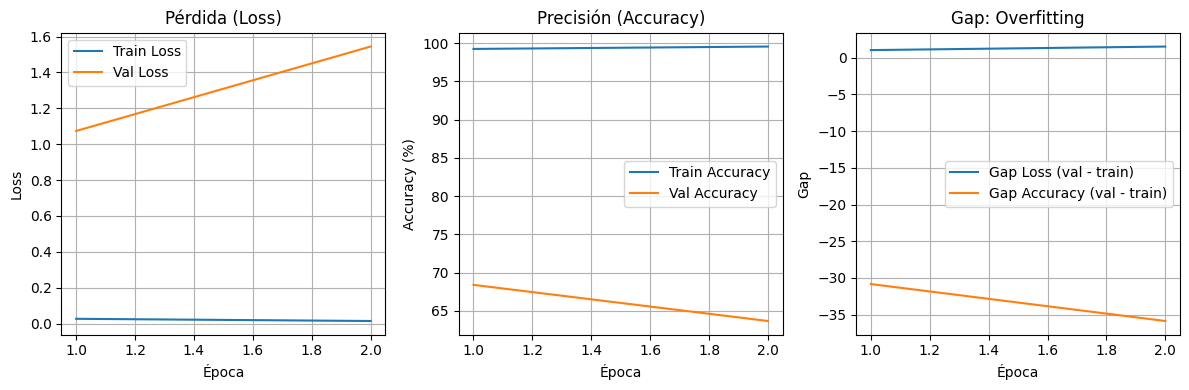

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

exp2 = pd.read_csv("training_metrics_clean2.csv")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Curva de Loss
axs[0].plot(exp2['epoch'], exp2['train_loss'], label='Train Loss')
axs[0].plot(exp2['epoch'], exp2['val_loss'], label='Val Loss')
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pérdida (Loss)")
axs[0].legend()
axs[0].grid(True)

# Curva de accuracy
axs[1].plot(exp2['epoch'], exp2['train_accuracy'], label='Train Accuracy')
axs[1].plot(exp2['epoch'], exp2['val_accuracy'], label='Val Accuracy')
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Precisión (Accuracy)")
axs[1].legend()
axs[1].grid(True)

# Gap Loss y Gap Accuracy
gap_loss = exp2['val_loss'] - exp2['train_loss']
gap_acc = exp2['val_accuracy'] - exp2['train_accuracy']
axs[2].plot(exp2['epoch'], gap_loss, label='Gap Loss (val - train)')
axs[2].plot(exp2['epoch'], gap_acc, label='Gap Accuracy (val - train)')
axs[2].set_xlabel("Época")
axs[2].set_ylabel("Gap")
axs[2].set_title("Gap: Overfitting")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# Tercer experimento
Experimento con batch size de 3, con un stride menor para aumentar la cantidad de clips, ahora que se puede tener un mayor batch físico. Se consiguen mejoras respecto al primer experimento en cuanto a métricas, pero aún el train loss es bajo y el gap loss alto.

In [55]:
%%time
EPOCHS = 10
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 3
STRIDE = 1.8
TRAIN_DIR = "./tav_clean/training"
VALIDATION_DIR = "./tav_clean/validacion"
OUTPUT_MODEL = "i3d_finetuned_violencia_robo_normal.pth"
METRICS_FILE = "training_metrics_clean.csv"

ckpt = torch.load("checkpoint_epoch_1.pth", map_location="cpu")

model = crear_modelo_i3d(
    dropout_p     = 0.5,
    freeze_backbone = False,
    pretrain_path = "I3D_8x8_R50_pytorchvideo.pyth",
    num_clases    = 3
)

missing, unexpected = model.load_state_dict(ckpt["model_state_dict"], strict=False)
print(f"🔁 Checkpoint cargado. Missing={len(missing)}, Unexpected={len(unexpected)}")

print(f"🔄 Congelando capas del modelo:")
for name, p in model.named_parameters():
    p.requires_grad = any(name.startswith(f"blocks.{i}") for i in [4,5]) or "head" in name

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE, weight_decay=1e-5
)
# Basado en la cantidad de frames por clase, calcular pesos para CrossEntropyLoss
cls_counts = np.array([165498, 172315, 141269], dtype=np.float32)

class_weights = 1.0 / cls_counts
class_weights = class_weights / class_weights.sum() * len(cls_counts)  

class_weights_t = torch.tensor(class_weights, dtype=torch.float32)
print("Pesos por clase  :", class_weights)  
print("Etiqueta 0 = Normal, 1 = Robo, 2 = Violencia")

train_loader, val_loader = recolectar_datasets()
entrenar_modelo(model, train_loader, val_loader, device, EPOCHS, config, class_weights_t)


🔄 Creando modelo I3D-ResNet50…
🔍 Detectado formato PyTorchVideo (.pyth)
✅ Pesos preentrenados cargados: 320/320 capas
✅ Head: Dropout 0.5  |  proyección → 3 clases
🔁 Checkpoint cargado. Missing=0, Unexpected=0
🔄 Congelando capas del modelo:
Pesos por clase  : [0.95787024 0.91997564 1.1221542 ]
Etiqueta 0 = Normal, 1 = Robo, 2 = Violencia

📂 Buscando videos de ENTRENAMIENTO en: ./tav_clean/training
✅ Total de videos de entrenamiento: 274

📊 [Resumen de videos por clase]
   Normal: 115 videos
   Robo: 83 videos
   Violencia: 76 videos


📂 Buscando videos de VALIDACIÓN en: ./tav_clean/validacion
✅ Total de videos de validación: 57

📊 [Resumen de videos por clase]
   Normal: 17 videos
   Robo: 22 videos
   Violencia: 18 videos


🔄 Creando datasets con sliding window...
📊 Total de clips generados: 8617
📊 Total de clips generados: 1280
✅ DataLoaders creados: 2872 batches de entrenamiento, 1280 batches de validación
✅ Mixed Precision habilitado (AMP)
🚀 Optimizaciones CUDA habilitadas (TF32, c

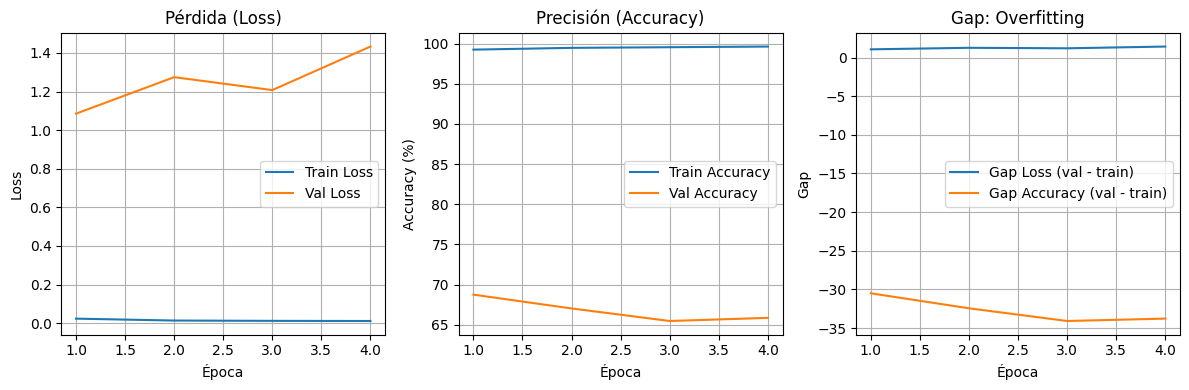

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

exp3 = pd.read_csv("training_metrics_clean3.csv")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Curva de Loss
axs[0].plot(exp3['epoch'], exp3['train_loss'], label='Train Loss')
axs[0].plot(exp3['epoch'], exp3['val_loss'], label='Val Loss')
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pérdida (Loss)")
axs[0].legend()
axs[0].grid(True)

# Curva de accuracy
axs[1].plot(exp3['epoch'], exp3['train_accuracy'], label='Train Accuracy')
axs[1].plot(exp3['epoch'], exp3['val_accuracy'], label='Val Accuracy')
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Precisión (Accuracy)")
axs[1].legend()
axs[1].grid(True)

# Gap Loss y Gap Accuracy
gap_loss = exp3['val_loss'] - exp3['train_loss']
gap_acc = exp3['val_accuracy'] - exp3['train_accuracy']
axs[2].plot(exp3['epoch'], gap_loss, label='Gap Loss (val - train)')
axs[2].plot(exp3['epoch'], gap_acc, label='Gap Accuracy (val - train)')
axs[2].set_xlabel("Época")
axs[2].set_ylabel("Gap")
axs[2].set_title("Gap: Overfitting")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Cuarto experimento
Último experimento realizado. Se consiguieron los mejores resultados en cuanto a métricas, aunque existe mucho margen de mejora. El train loss sube y el val loss baja, y de los intentos realizados debiera ser el que mejor generaliza (menor gap loss)

In [65]:
%%time
EPOCHS = 10
LEARNING_RATE = 5e-6
EARLY_STOPPING_PATIENCE = 3
STRIDE = 1.8
LABEL_SMOOTH = 0.10 
TRAIN_DIR = "./tav_clean/training"
VALIDATION_DIR = "./tav_clean/validacion"
OUTPUT_MODEL = "i3d_finetuned_violencia_robo_normal.pth"
METRICS_FILE = "training_metrics_clean.csv"

best_weights = torch.load("i3d_finetuned_violencia_robo_normal.pth", map_location="cpu")

model = crear_modelo_i3d(
        dropout_p=0.6,
        freeze_backbone=False,
        pretrain_path=None,
        num_clases=3
)
model.load_state_dict(best_weights)

# Congelar bloques 0-4 y entrenar sólo blocks.5 + head
for n, p in model.named_parameters():
    p.requires_grad = n.startswith("blocks.5") or "head" in n

frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔒 Frozen: {frozen:,}  |  🔓 Trainable: {trainable:,}")

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

cls_counts = torch.tensor([165498, 172315, 141269], dtype=torch.float32)
class_weights = (1. / cls_counts)
class_weights = class_weights / class_weights.sum() * len(cls_counts)
print("Pesos por clase:", class_weights.numpy())   
print("Etiqueta 0 = Normal, 1 = Robo, 2 = Violencia")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2
)

train_loader, val_loader = recolectar_datasets()

entrenar_modelo(
    model,
    train_loader,
    val_loader,
    device,
    EPOCHS,
    config,
    class_weights.to(device)  
)


🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.6  |  proyección → 3 clases
🔒 Frozen: 10,168,131  |  🔓 Trainable: 17,061,888
Pesos por clase: [0.95787024 0.91997564 1.1221542 ]
Etiqueta 0 = Normal, 1 = Robo, 2 = Violencia

📂 Buscando videos de ENTRENAMIENTO en: ./tav_clean/training
✅ Total de videos de entrenamiento: 274

📊 [Resumen de videos por clase]
   Normal: 115 videos
   Robo: 83 videos
   Violencia: 76 videos


📂 Buscando videos de VALIDACIÓN en: ./tav_clean/validacion
✅ Total de videos de validación: 57

📊 [Resumen de videos por clase]
   Normal: 17 videos
   Robo: 22 videos
   Violencia: 18 videos


🔄 Creando datasets con sliding window...
📊 Total de clips generados: 8617
📊 Total de clips generados: 1280
✅ DataLoaders creados: 2872 batches de entrenamiento, 1280 batches de validación
✅ Mixed Precision habilitado (AMP)
🚀 Optimizaciones CUDA habilitadas (TF32, cuDNN benchmark)
📊 VRAM disponible: 4.3 GB

🚀 [Entrenamiento iniciado en cuda:0]
📋 Configuración: 10 épocas, batch_siz

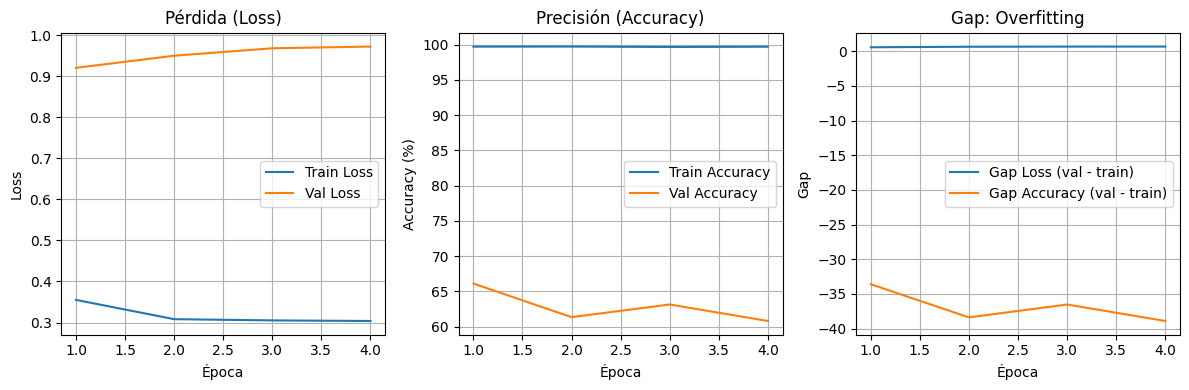

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

exp4 = pd.read_csv("training_metrics_clean4.csv")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Curva de Loss
axs[0].plot(exp4['epoch'], exp4['train_loss'], label='Train Loss')
axs[0].plot(exp4['epoch'], exp4['val_loss'], label='Val Loss')
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pérdida (Loss)")
axs[0].legend()
axs[0].grid(True)

# Curva de accuracy
axs[1].plot(exp4['epoch'], exp4['train_accuracy'], label='Train Accuracy')
axs[1].plot(exp4['epoch'], exp4['val_accuracy'], label='Val Accuracy')
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Precisión (Accuracy)")
axs[1].legend()
axs[1].grid(True)

# Gap Loss y Gap Accuracy
gap_loss = exp4['val_loss'] - exp4['train_loss']
gap_acc = exp4['val_accuracy'] - exp4['train_accuracy']
axs[2].plot(exp4['epoch'], gap_loss, label='Gap Loss (val - train)')
axs[2].plot(exp4['epoch'], gap_acc, label='Gap Accuracy (val - train)')
axs[2].set_xlabel("Época")
axs[2].set_ylabel("Gap")
axs[2].set_title("Gap: Overfitting")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Experimento Dataset original ("Experimento 0")
Realizado en otro Jupyter. Se insertan métricas resultantes para documentación y comparación

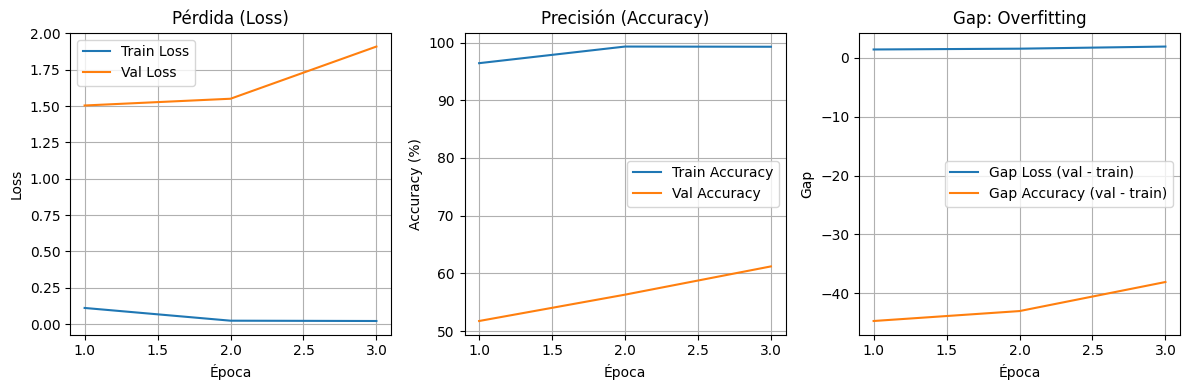

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

exp0 = pd.read_csv("training_metrics_raw.csv")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Curva de Loss
axs[0].plot(exp0['epoch'], exp0['train_loss'], label='Train Loss')
axs[0].plot(exp0['epoch'], exp0['val_loss'], label='Val Loss')
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Loss")
axs[0].set_title("Pérdida (Loss)")
axs[0].legend()
axs[0].grid(True)

# Curva de accuracy
axs[1].plot(exp0['epoch'], exp0['train_accuracy'], label='Train Accuracy')
axs[1].plot(exp0['epoch'], exp0['val_accuracy'], label='Val Accuracy')
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Precisión (Accuracy)")
axs[1].legend()
axs[1].grid(True)

# Gap Loss y Gap Accuracy
gap_loss = exp0['val_loss'] - exp0['train_loss']
gap_acc = exp0['val_accuracy'] - exp0['train_accuracy']
axs[2].plot(exp0['epoch'], gap_loss, label='Gap Loss (val - train)')
axs[2].plot(exp0['epoch'], gap_acc, label='Gap Accuracy (val - train)')
axs[2].set_xlabel("Época")
axs[2].set_ylabel("Gap")
axs[2].set_title("Gap: Overfitting")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

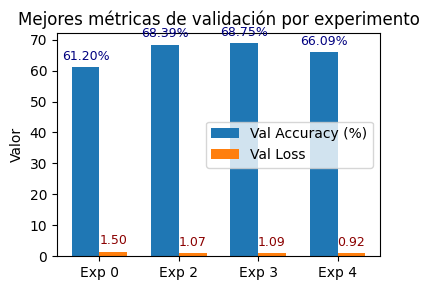

In [19]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Exp 0','Exp 2', 'Exp 3', 'Exp 4' ]
val_acc = [exp0['val_accuracy'].max(),exp2['val_accuracy'].max(), exp3['val_accuracy'].max(), exp4['val_accuracy'].max()]
val_loss = [exp0['val_loss'].min(), exp2['val_loss'].min(), exp3['val_loss'].min(), exp4['val_loss'].min()]

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(4, 3))

bars1 = ax.bar(x - width/2, val_acc, width, label='Val Accuracy (%)')
bars2 = ax.bar(x + width/2, val_loss, width, label='Val Loss')

# Se incluyen etiquetas en las barras
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='navy')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='darkred')

ax.set_ylabel('Valor')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Mejores métricas de validación por experimento')
ax.legend()
plt.tight_layout()
plt.show()


# Evaluación sobre test set
El siguiente flujo es para evaluar los modelos usándolos para hacer inferencia sobre el test set. Se toman los best_model conseguidos en cada caso y luego se pueden comparar métricas

🗂️  Videos de test: 47
📊 Total de clips generados: 5268

🔍 Evaluando exp1_clean
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.3  |  proyección → 3 clases


infer:   0%|          | 1/1756 [00:01<55:49,  1.91s/it]

⏱️ Primer batch: 0.52 s. Total batches: 1756. Estimado total: 15.1 min


infer:   0%|          | 5/1756 [00:13<1:23:07,  2.85s/it]

⏱️ Batch promedio (1-5): 0.51 s. Estimado total: 15.0 min



🔍 Evaluando exp3_clean
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.5  |  proyección → 3 clases


infer:   0%|          | 1/1756 [00:02<1:06:45,  2.28s/it]

⏱️ Primer batch: 0.50 s. Total batches: 1756. Estimado total: 14.7 min


infer:   0%|          | 5/1756 [00:15<1:36:21,  3.30s/it]

⏱️ Batch promedio (1-5): 0.50 s. Estimado total: 14.7 min



🔍 Evaluando exp4_clean
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.6  |  proyección → 3 clases


infer:   0%|          | 1/1756 [00:01<57:29,  1.97s/it]

⏱️ Primer batch: 0.49 s. Total batches: 1756. Estimado total: 14.4 min


infer:   0%|          | 5/1756 [00:14<1:29:29,  3.07s/it]

⏱️ Batch promedio (1-5): 0.49 s. Estimado total: 14.4 min



🔍 Evaluando exp_raw
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.3  |  proyección → 3 clases


infer:   0%|          | 1/1756 [00:01<57:42,  1.97s/it]

⏱️ Primer batch: 0.50 s. Total batches: 1756. Estimado total: 14.5 min


infer:   0%|          | 5/1756 [00:14<1:27:27,  3.00s/it]

⏱️ Batch promedio (1-5): 0.49 s. Estimado total: 14.4 min


    Modelo      Acc  F1-Viol  F1-Robo  F1-Norm
exp3_clean 0.476841 0.357844 0.204098 0.746396
   exp_raw 0.460137 0.552669 0.224905 0.545401
exp1_clean 0.449696 0.422228 0.141713 0.669329
exp4_clean 0.447798 0.405680 0.161085 0.700084


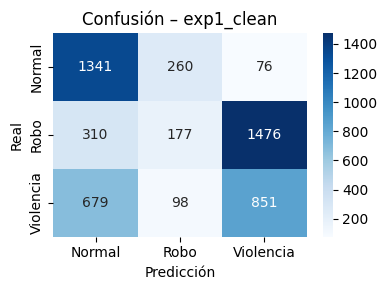

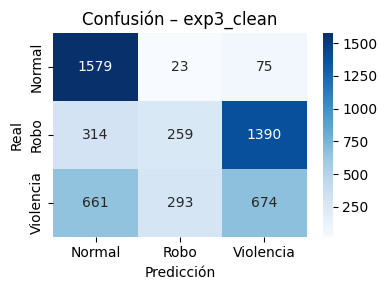

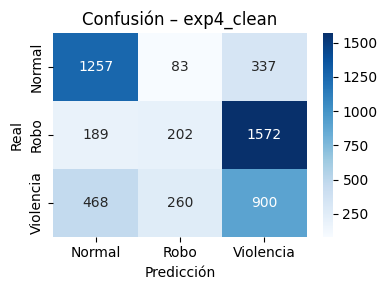

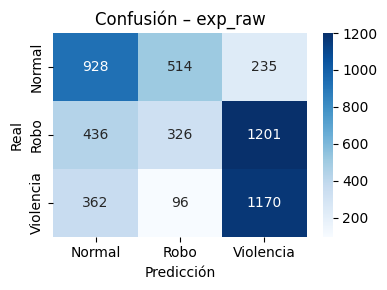

CPU times: total: 1d 52min 55s
Wall time: 5h 43min 41s


In [86]:
%%time
import torch, numpy as np, pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns; import matplotlib.pyplot as plt

CLIP_DURATION = 2.56       
NUM_FRAMES    = 32
STRIDE        = 1.0
BATCH_SIZE    = 3       # Cambiar según VRAM disponible
DEVICE        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODELOS
MODELS = {
    "exp1_clean"  : ("best_i3d_exp1.pth", 0.30, (0,1,2,3,4)),
    "exp3_clean"  : ("best_i3d_exp3.pth", 0.50, (0,1,2,3)),
    "exp4_clean"  : ("best_i3d_exp4.pth", 0.60, (0,1,2,3,4)),
    "exp_raw"     : ("i3d_finetuned_violencia_robo_normal.pth", 0.30, (0,1,2,3,4,5))  # (si no se usó dropout, se pone None)
}

# DATASET DE TEST
TEST_DIR = Path("./tav_clean/testing")                     # Cambiar según estructura de carpetas
LABELS = ["Normal", "Robo", "Violencia"]

test_paths = []
for label_idx, label_name in enumerate(LABELS):
    for video in (TEST_DIR / label_name).glob("*.mp4"):
        test_paths.append((video, label_idx))

print(f"🗂️  Videos de test: {len(test_paths)}")

test_dataset = SlidingWindowVideoDataset(
    video_paths=test_paths,
    clip_duration=CLIP_DURATION,
    stride=STRIDE,
    num_frames=NUM_FRAMES,
    transform=VAL_TRANSFORM            
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

# EVALUACIÓN DE MODELOS
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, desc="infer", leave=False)):
            x  = batch["video"].to(DEVICE, non_blocking=True)
            yt = batch["label"].to(DEVICE, non_blocking=True)
            yp = model(x).argmax(1)
            y_true.append(yt.cpu())
            y_pred.append(yp.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    rep = classification_report(
        y_true, y_pred, target_names=LABELS, digits=4, output_dict=True)
    cm  = confusion_matrix(y_true, y_pred)

    return rep, cm


results = {}
for nickname, (ckpt_path, dp, freeze_set) in MODELS.items():
    print(f"\n🔍 Evaluando {nickname}")
    model = crear_modelo_i3d(
                dropout_p=dp,      
                freeze_backbone=False,
                pretrain_path=None,
                num_clases=3)
    state = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(state, strict=True)
    model.to(DEVICE)

    rep, cm = evaluate(model, test_loader)
    results[nickname] = {"rep": rep, "cm": cm}

# Resumen de resultados
rows = []
for name, out in results.items():
    rows.append([
        name,
        out["rep"]["accuracy"],
        out["rep"]["Violencia"]["f1-score"],
        out["rep"]["Robo"]["f1-score"],
        out["rep"]["Normal"]["f1-score"]
    ])
df = pd.DataFrame(rows, columns=["Modelo","Acc","F1-Viol","F1-Robo","F1-Norm"])
print(df.sort_values("Acc", ascending=False).to_string(index=False))

# Matrices de confusión
for name, out in results.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(out["cm"], annot=True, fmt="d",
                xticklabels=LABELS, yticklabels=LABELS, cmap="Blues")
    plt.title(f"Confusión – {name}")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

In [85]:
import torch

# Carga tu modelo como siempre (puedes poner cualquier dropout temporal)
model = crear_modelo_i3d(dropout_p=0.3, pretrain_path=None, num_clases=3)
state = torch.load("i3d_finetuned_violencia_robo_normal.pth", map_location="cpu")
model.load_state_dict(state, strict=True)

# Busca capas Dropout activas
dropouts = [(name, m.p) for name, m in model.named_modules() if isinstance(m, torch.nn.Dropout)]
if not dropouts:
    print("No se encontraron capas Dropout en el modelo.")
else:
    for name, p in dropouts:
        print(f"Dropout: {name}  ->  p={p}")


🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout 0.3  |  proyección → 3 clases
🧊  Capas congeladas: 129  |  Entrenables: 32
Dropout: blocks.6.dropout  ->  p=0.3


🗂️  Videos de test: 47
📊 Total de clips generados: 2647

🔍 Evaluando exp3_clean
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout p=0.5
   ↳ proyección → 3 clases



Resultados por CLIP para modelo exp3_clean:
              precision    recall  f1-score   support

      Normal     0.6189    0.9419    0.7469       843
        Robo     0.4712    0.1410    0.2170       986
   Violencia     0.3190    0.4169    0.3614       818

    accuracy                         0.4813      2647
   macro avg     0.4697    0.4999    0.4418      2647
weighted avg     0.4712    0.4813    0.4304      2647



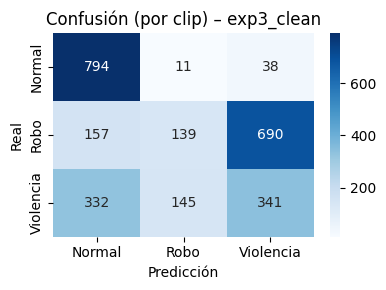

CSV exportado: exp3_clean_video_preds_probs.csv

Resultados por VIDEO para modelo exp3_clean:
              precision    recall  f1-score   support

      Normal     0.8462    0.6875    0.7586        16
        Robo     0.3636    0.2500    0.2963        16
   Violencia     0.4783    0.7333    0.5789        15

    accuracy                         0.5532        47
   macro avg     0.5627    0.5569    0.5446        47
weighted avg     0.5645    0.5532    0.5439        47



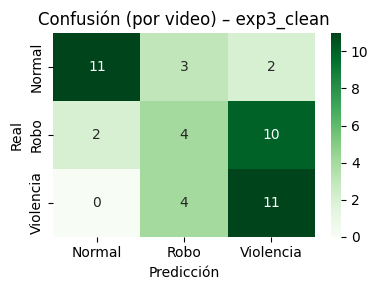


🔍 Evaluando exp4_clean
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout p=0.6
   ↳ proyección → 3 clases



Resultados por CLIP para modelo exp4_clean:
              precision    recall  f1-score   support

      Normal     0.6570    0.7497    0.7003       843
        Robo     0.3816    0.1095    0.1702       986
   Violencia     0.3210    0.5501    0.4054       818

    accuracy                         0.4496      2647
   macro avg     0.4532    0.4698    0.4253      2647
weighted avg     0.4506    0.4496    0.4117      2647



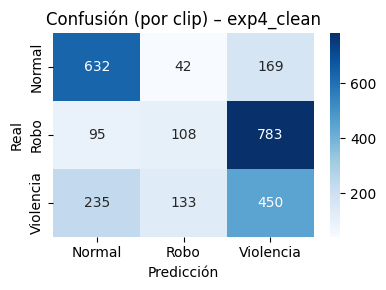

CSV exportado: exp4_clean_video_preds_probs.csv

Resultados por VIDEO para modelo exp4_clean:
              precision    recall  f1-score   support

      Normal     0.7500    0.5625    0.6429        16
        Robo     0.3750    0.1875    0.2500        16
   Violencia     0.4444    0.8000    0.5714        15

    accuracy                         0.5106        47
   macro avg     0.5231    0.5167    0.4881        47
weighted avg     0.5248    0.5106    0.4863        47



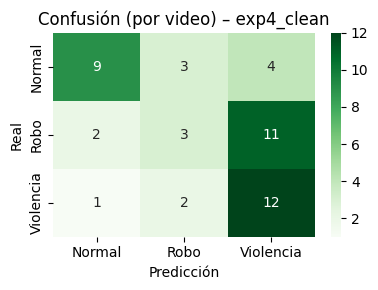


🔍 Evaluando exp_raw
🔄 Creando modelo I3D-ResNet50…
✅ Head: Dropout p=0.3
   ↳ proyección → 3 clases



Resultados por CLIP para modelo exp_raw:
              precision    recall  f1-score   support

      Normal     0.5399    0.5540    0.5468       843
        Robo     0.3526    0.1673    0.2270       986
   Violencia     0.4490    0.7213    0.5535       818

    accuracy                         0.4617      2647
   macro avg     0.4472    0.4809    0.4424      2647
weighted avg     0.4420    0.4617    0.4297      2647



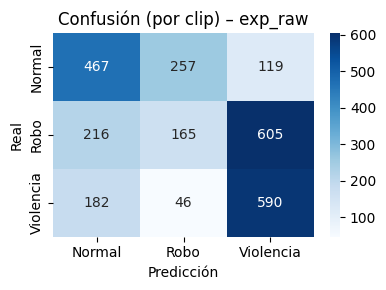

CSV exportado: exp_raw_video_preds_probs.csv

Resultados por VIDEO para modelo exp_raw:
              precision    recall  f1-score   support

      Normal     0.8750    0.4375    0.5833        16
        Robo     0.4000    0.2500    0.3077        16
   Violencia     0.4828    0.9333    0.6364        15

    accuracy                         0.5319        47
   macro avg     0.5859    0.5403    0.5091        47
weighted avg     0.5881    0.5319    0.5064        47



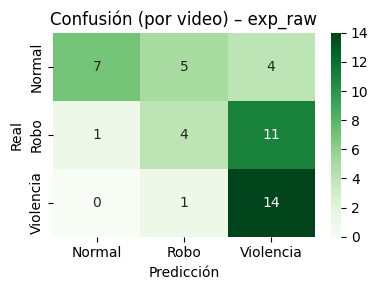

CPU times: total: 9h 10min 42s
Wall time: 2h 9min 53s


In [23]:
%%time
import torch, numpy as np, pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns; import matplotlib.pyplot as plt
from collections import defaultdict

CLIP_DURATION = 2.56       
NUM_FRAMES    = 32
STRIDE        = 2.0
BATCH_SIZE    = 5
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LABELS = ["Normal", "Robo", "Violencia"]

MODELS = {
    "exp3_clean"  : ("best_i3d_exp3.pth", 0.50, (0,1,2,3)),
    "exp4_clean"  : ("best_i3d_exp4.pth", 0.60, (0,1,2,3,4)),
    "exp_raw"     : ("i3d_finetuned_violencia_robo_normal.pth", 0.30, (0,1,2,3,4,5))
}

TEST_DIR = Path("./tav_clean/testing")
test_paths = []
for label_idx, label_name in enumerate(LABELS):
    for video in (TEST_DIR / label_name).glob("*.mp4"):
        test_paths.append((video, label_idx))
print(f"🗂️  Videos de test: {len(test_paths)}")

test_dataset = SlidingWindowVideoDataset(
    video_paths=test_paths,
    clip_duration=CLIP_DURATION,
    stride=STRIDE,
    num_frames=NUM_FRAMES,
    transform=VAL_TRANSFORM            
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    clip_info = []  # (video_id, true_label, pred_label, [prob_normal, prob_robo, prob_viol])
    with torch.no_grad():
        for batch in tqdm(loader, desc="infer", leave=False):
            x  = batch["video"].to(DEVICE, non_blocking=True)
            yt = batch["label"].to(DEVICE, non_blocking=True)
            video_ids = batch["video_id"]  # asegúrate de tener esto en el __getitem__ de tu dataset
            logits = model(x)  # shape (B, 3)
            probs = torch.softmax(logits, dim=1)  # shape (B, 3)
            yp = probs.argmax(1)
            y_true.append(yt.cpu())
            y_pred.append(yp.cpu())
            for vid, true, pred, prob in zip(video_ids, yt.cpu().numpy(), yp.cpu().numpy(), probs.cpu().numpy()):
                clip_info.append((vid, true, pred, prob))
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    rep = classification_report(y_true, y_pred, target_names=LABELS, digits=4, output_dict=True)
    cm  = confusion_matrix(y_true, y_pred)
    return rep, cm, clip_info

def agregacion_por_video_probs_csv_normal_default(clip_info, nickname):
    preds_dict = defaultdict(list)
    probs_dict = defaultdict(list)
    video_true = {}

    for video_id, true_label, pred_label, prob in clip_info:
        preds_dict[video_id].append(pred_label)
        probs_dict[video_id].append(prob)
        video_true[video_id] = true_label

    rows = []
    for video_id in preds_dict:
        probs = np.stack(probs_dict[video_id])  # (num_clips, 3)
        prob_avg = probs.mean(axis=0)  # promedio por clase
        n_clips = probs.shape[0]
        n_robo = np.sum(np.argmax(probs, axis=1) == 1)
        n_viol = np.sum(np.argmax(probs, axis=1) == 2)
        n_normal = np.sum(np.argmax(probs, axis=1) == 0)

        
        # Votacion por mayoría simple
        pred_counts = np.bincount(preds_dict[video_id], minlength=len(LABELS))
        pred = np.argmax(pred_counts)  # clase con más votos
  
        rows.append({
            "video": Path(str(video_id)).name,
            "true_label": LABELS[video_true[video_id]],
            "pred_label": LABELS[pred],
            "prob_Normal": prob_avg[0],
            "prob_Robo": prob_avg[1],
            "prob_Violencia": prob_avg[2],
            "n_clips": n_clips,
            "n_normal": n_normal,
            "n_robo": n_robo,
            "n_violencia": n_viol,
            "acierto": int(pred == video_true[video_id])
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"{nickname}_video_preds_probs.csv", index=False)
    print(f"CSV exportado: {nickname}_video_preds_probs.csv")

    y_true_v = np.array([LABELS.index(row["true_label"]) for row in rows])
    y_pred_v = np.array([LABELS.index(row["pred_label"]) for row in rows])
    return y_true_v, y_pred_v, df

# --- FLUJO PRINCIPAL ---
results = {}
for nickname, (ckpt_path, dp, freeze_set) in MODELS.items():
    print(f"\n🔍 Evaluando {nickname}")
    model = crear_modelo_i3d(
        dropout_p=dp,      
        freeze_backbone=False,
        pretrain_path=None,
        num_clases=3)
    state = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(state, strict=True)
    model.to(DEVICE)

    rep, cm, clip_info = evaluate(model, test_loader)
    results[nickname] = {"rep": rep, "cm": cm, "clip_info": clip_info}

    print(f"\nResultados por CLIP para modelo {nickname}:")
    y_true_clip = np.array([c[1] for c in clip_info])
    y_pred_clip = np.array([c[2] for c in clip_info])
    print(classification_report(y_true_clip, y_pred_clip, target_names=LABELS, digits=4))

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS, cmap="Blues")
    plt.title(f"Confusión (por clip) – {nickname}")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

    y_true_v, y_pred_v, df_csv = agregacion_por_video_probs_csv_normal_default(clip_info, nickname)
    print(f"\nResultados por VIDEO para modelo {nickname}:")
    print(classification_report(y_true_v, y_pred_v, target_names=LABELS, digits=4))
    cm_v = confusion_matrix(y_true_v, y_pred_v)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_v, annot=True, fmt="d", xticklabels=LABELS, yticklabels=LABELS, cmap="Greens")
    plt.title(f"Confusión (por video) – {nickname}")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef

# Por clip
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Macro F1: {f1_macro:.3f} | Weighted F1: {f1_weighted:.3f} | MCC: {mcc:.3f}")

# Por video
f1_macro_v = f1_score(y_true_v, y_pred_v, average='macro')
f1_weighted_v = f1_score(y_true_v, y_pred_v, average='weighted')
mcc_v = matthews_corrcoef(y_true_v, y_pred_v)
print(f"Por VIDEO – Macro F1: {f1_macro_v:.3f} | Weighted F1: {f1_weighted_v:.3f} | MCC: {mcc_v:.3f}")
